<a href="https://colab.research.google.com/github/muajnstu/DSK-Chain-to-predict-diabeties-/blob/main/Freidman_Test_on_refined_method_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-posthocs

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
from scipy.stats import rankdata
import scikit_posthocs as sp
import altair as alt
from scipy.stats import friedmanchisquare, rankdata
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


In [4]:
df=pd.read_csv('https://raw.githubusercontent.com/muajnstu/DSK-Chain-to-predict-diabeties-/refs/heads/main/Debugged%20fold-wise%20result.csv')
display(df.head())

,Classifiers,GB,Unnamed: 2,Unnamed: 3,LGBM,Unnamed: 5,Unnamed: 6,ET,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,QDA,Unnamed: 26,Unnamed: 27,DSK-chain,Unnamed: 29,Unnamed: 30,XGB,Unnamed: 32,Unnamed: 33
0,Fold,Accuracy,AUC,F-Measure,Accuracy,AUC,F-Measure,Accuracy,AUC,F-Measure,...,F-Measure,Accuracy,AUC,F-Measure,Accuracy,AUC,F-Measure,Accuracy,AUC,F-Measure
1,Fold 1,0.8193,0.7253,0.5148,0.8193,0.6935,0.5383,0.7380,0.4648,0.4961,...,0.4543,0.2590,0.5435,0.2548,0.9624,0.9874,0.9623,0.8012,0.6964,0.5259
2,Fold 2,0.8163,0.7286,0.4869,0.8102,0.7050,0.4839,0.7425,0.4415,0.4861,...,0.4558,0.2651,0.5961,0.2618,0.9733,0.9875,0.9730,0.8102,0.7081,0.5032
3,Fold 3,0.8193,0.6639,0.4953,0.8208,0.6516,0.5279,0.7410,0.4446,0.5098,...,0.4480,0.2620,0.5880,0.2585,0.9575,0.9838,0.9573,0.8163,0.6544,0.5306
4,Fold 4,0.8223,0.7197,0.5103,0.8163,0.7019,0.5190,0.7364,0.4958,0.4649,...,0.4490,0.2726,0.5974,0.2708,0.9713,0.9890,0.9712,0.8057,0.6989,0.5066


In [15]:
print(df.columns.tolist())

['Classifiers ', 'GB', 'Unnamed: 2', 'Unnamed: 3', ' LGBM ', 'Unnamed: 5', 'Unnamed: 6', ' ET', 'Unnamed: 8', 'Unnamed: 9', 'Bagging', 'Unnamed: 11', 'Unnamed: 12', 'DT', 'Unnamed: 14', 'Unnamed: 15', 'NB', 'Unnamed: 17', 'Unnamed: 18', 'RF', 'Unnamed: 20', 'Unnamed: 21', 'LDA', 'Unnamed: 23', 'Unnamed: 24', 'QDA', 'Unnamed: 26', 'Unnamed: 27', 'DSK-chain', 'Unnamed: 29', 'Unnamed: 30', 'XGB', 'Unnamed: 32', 'Unnamed: 33']


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare, rankdata

df.columns = df.columns.str.strip()

accuracy_columns = [
    'GB', 'LGBM', 'ET',
    'Bagging', 'DT',
    'NB', 'RF', 'LDA', 'QDA', 'DSK-chain', 'XGB'
]

# Filter out non-numeric rows
mask = df[accuracy_columns].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull().all(axis=1)
filtered_df = df[accuracy_columns][mask]

accuracy_data = [filtered_df[col].astype(float).values for col in accuracy_columns]

# Friedman test
statistic, p_value = friedmanchisquare(*accuracy_data)
print("Friedman Chi-square statistic:", statistic)
print("p-value:", p_value)

accuracy_matrix = np.array(accuracy_data).T
ranks = np.array([rankdata(-row) for row in accuracy_matrix])
avg_ranks = ranks.mean(axis=0)

rank_df = pd.DataFrame({
    'Classifier': accuracy_columns,
    'Average Rank': avg_ranks
}).sort_values("Average Rank")

print(rank_df)

Friedman Chi-square statistic: 97.32695810564661
p-value: 1.8652670832751686e-16
   Classifier  Average Rank
9   DSK-chain          1.00
0          GB          2.30
1        LGBM          3.05
7         LDA          4.15
10        XGB          4.50
6          RF          6.20
3     Bagging          7.30
2          ET          7.50
4          DT          9.00
8         QDA         10.10
5          NB         10.90


In [6]:
# Step 1: Friedman test
statistic, p_value = friedmanchisquare(*accuracy_data)

# Step 2: Average ranks
accuracy_matrix = np.array(accuracy_data).T
ranks = np.array([rankdata(-row) for row in accuracy_matrix])
avg_ranks = ranks.mean(axis=0)

# Step 3: Identify best model
best_idx = np.argmin(avg_ranks)
best_model = accuracy_columns[best_idx]

# Step 4: Nemenyi post hoc p-values
p_values_matrix = sp.posthoc_nemenyi_friedman(accuracy_matrix)
p_values = p_values_matrix.iloc[best_idx].values

# Step 5: Compute z-values
k = len(accuracy_columns)
N = accuracy_matrix.shape[0]
q = np.sqrt(k*(k+1)/(6*N))
z_values = np.abs(avg_ranks - avg_ranks[best_idx]) / q

# Step 6: Adjust p-values (Bonferroni, Holm, Hochberg)
p_bonf = multipletests(p_values, method='bonferroni')[1]
p_holm = multipletests(p_values, method='holm')[1]
p_hoch = multipletests(p_values, method='h')[1]

# Step 7: Holland correction
sorted_idx = np.argsort(p_values)
p_sorted = p_values[sorted_idx]
p_holland_sorted = [1 - (1 - p_sorted[i])**(k - i) for i in range(k)]
# Reorder back to original order
p_holland = np.empty_like(p_holland_sorted)
p_holland[sorted_idx] = p_holland_sorted

# Step 8: Combine results
result_df = pd.DataFrame({
    'Model': accuracy_columns,
    'Ranking': avg_ranks,
    'z': z_values,
    'p': p_values,
    'p_Bonf': p_bonf,
    'p_Holm': p_holm,
    'p_Hochberg': p_hoch,
    'p_Holland': p_holland
}).sort_values("Ranking").reset_index(drop=True)

print("Best Model:", best_model)
display(result_df)


Best Model: DSK-chain


,Model,Ranking,z,p,p_Bonf,p_Holm,p_Hochberg,p_Holland
0,DSK-chain,1.00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,GB,2.30,0.876460,9.986141e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999981e-01
2,LGBM,3.05,1.382110,9.529585e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.998959e-01
3,LDA,4.15,2.123730,5.600386e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.625322e-01
4,XGB,4.50,2.359700,3.929789e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.175826e-01
5,RF,6.20,3.505839,1.968201e-02,2.165021e-01,1.180920e-01,1.180920e-01,1.124316e-01
6,Bagging,7.30,4.247459,1.093827e-03,1.203210e-02,7.656790e-03,7.656790e-03,7.631710e-03
7,ET,7.50,4.382299,6.035669e-04,6.639236e-03,4.828535e-03,4.828535e-03,4.818347e-03
8,DT,9.00,5.393599,3.754217e-06,4.129639e-05,3.378795e-05,3.378795e-05,3.378744e-05
9,QDA,10.10,6.135219,4.665242e-08,5.131766e-07,4.665242e-07,4.665242e-07,4.665241e-07


In [20]:
from google.colab import files

result_df.to_csv('statistical_results.csv', index=False)
files.download('statistical_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import altair as alt

chart = alt.Chart(rank_df).mark_line().encode(
    x='Classifier',
    y='Average Rank'
).properties(
    width=800,
    height=500
)

# Display the chart
chart

alt.Chart(...)

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000e+00,0.999991,0.019682,0.030917,0.000326,3.669147e-07,0.233393,0.976993,7.857493e-06,9.986141e-01,0.925684
1,9.999908e-01,1.000000,0.094088,0.134197,0.002946,6.544001e-06,0.560039,0.999680,1.061719e-04,9.529585e-01,0.996531
2,1.968201e-02,0.094088,1.000000,1.000000,0.995424,4.391141e-01,0.998614,0.462816,8.076969e-01,6.035669e-04,0.633023
3,3.091737e-02,0.134197,1.000000,1.000000,0.987730,3.489663e-01,0.999680,0.560039,7.256197e-01,1.093827e-03,0.725620
4,3.264107e-04,0.002946,0.995424,0.987730,1.000000,9.721461e-01,0.725620,0.042691,9.996796e-01,3.754217e-06,0.085730
5,3.669147e-07,0.000007,0.439114,0.348966,0.972146,1.000000e+00,0.058120,0.000279,9.999830e-01,1.362643e-09,0.000815
6,2.333930e-01,0.560039,0.998614,0.999680,0.725620,5.811980e-02,1.000000,0.952958,2.333930e-01,1.968201e-02,0.987730
7,9.769926e-01,0.999680,0.462816,0.560039,0.042691,2.790470e-04,0.952958,1.000000,2.946316e-03,5.600386e-01,1.000000
8,7.857493e-06,0.000106,0.807697,0.725620,0.999680,9.999830e-01,0.233393,0.002946,1.000000e+00,4.665242e-08,0.007434
9,9.986141e-01,0.952958,0.000604,0.001094,0.000004,1.362643e-09,0.019682,0.560039,4.665242e-08,1.000000e+00,0.392979


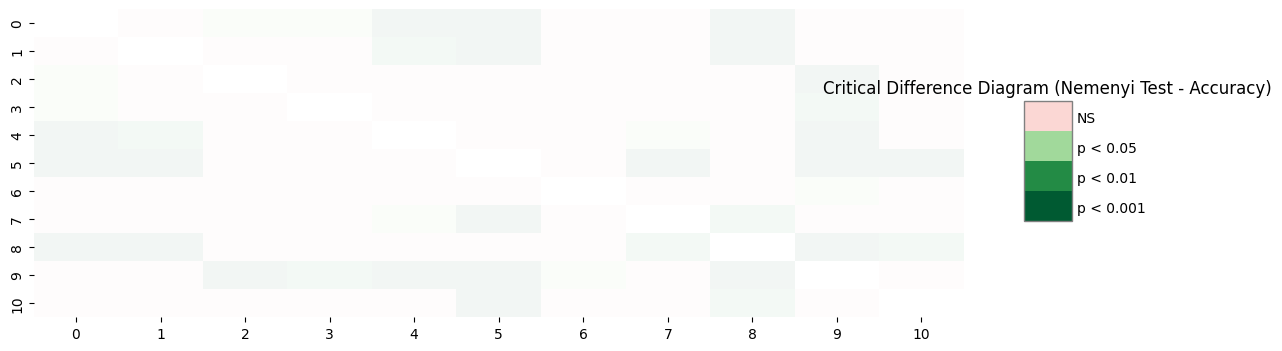

In [8]:
# Nemenyi post hoc test on the ranks
nemenyi_result = sp.posthoc_nemenyi_friedman(ranks)
display(nemenyi_result)

# Plot the Critical Difference Diagram
plt.figure(figsize=(12, 4))
sp.sign_plot(nemenyi_result, accuracy_columns, alpha=0.05)
plt.title("Critical Difference Diagram (Nemenyi Test - Accuracy)")
plt.show()